In [1]:
import numpy as np 
import pandas as pd
import os

In [2]:
import mlflow

HOST = "http://mlflow:5500"
EXPERIMENT_NAME = "FlightsDelay-mluser"

os.environ['MLFLOW_S3_ENDPOINT_URL']='http://minio-ml-workshop:9000'
os.environ['AWS_ACCESS_KEY_ID']='minio'
os.environ['AWS_REGION']='us-east-1'
os.environ['AWS_BUCKET_NAME']='mlflow'

# Connect to local MLflow tracking server
mlflow.set_tracking_uri(HOST)

# Set the experiment name...
mlflow.set_experiment(EXPERIMENT_NAME)

mlflow.sklearn.autolog(log_input_examples=True)


In [3]:
import pyarrow.parquet as pq
import s3fs

fs = s3fs.S3FileSystem(anon=True, 
                       key='minio', 
                       secret='minio123',
                       client_kwargs=dict(endpoint_url="http://minio-ml-workshop:9000"))
fs.ls("flights-data/flights-clean")
# 
df = pq.ParquetDataset('s3://flights-data/flights-clean', filesystem = fs).read_pandas().to_pandas()

In [4]:
df.isnull().sum().sort_values(ascending = False)

cancellation_reason    5245484
late_aircraft_delay    4329554
weather_delay          4329554
airline_delay          4329554
security_delay         4329554
air_system_delay       4329554
air_time                101784
arrival_delay           101784
elapsed_time            101784
wheels_on                89942
arrival_time             89942
taxi_in                  89942
wheels_off               86612
taxi_out                 86612
departure_time           83814
departure_delay          83814
tail_number              14367
DEST_LATITUDE             4610
DEST_LONGITUDE            4610
ORIG_LATITUDE             4605
ORIG_LONGITUDE            4605
scheduled_time               6
DEST_CITY                    0
DEST_AIRPORT                 0
ORIG_STATE                   0
ORIG_CITY                    0
ORIG_AIRPORT                 0
AL_AIRLINE                   0
DEST_STATE                   0
month                        0
cancelled                    0
diverted                     0
day     

In [5]:
#drop the columns for which the dataset has missing data for a large number of rows
df = df.drop(["cancellation_reason","late_aircraft_delay","weather_delay",
              "airline_delay", "security_delay", "air_system_delay"], axis=1)

# tail number doesnot seems to effect the predictions
df = df.drop(["tail_number"], axis=1)



In [6]:
#drop columns that will not be available for predicting future flights
df = df.dropna(subset=["scheduled_time", "departure_delay", 
                       "departure_time", "taxi_out","wheels_off", "taxi_in", "arrival_time",
                       "wheels_on", "elapsed_time", "arrival_delay","air_time", 
                       "DEST_LONGITUDE", "DEST_LATITUDE", "ORIG_LONGITUDE", "ORIG_LATITUDE"])

In [7]:
df = df.drop(["departure_time","arrival_time","wheels_on", 
              "wheels_off", "departure_delay", "arrival_delay", "diverted", 
              "cancelled", "taxi_in", "taxi_out"], axis=1)


In [8]:
df["scheduled_departure_hour"] = df.scheduled_departure.str[:2].astype(int)
df["scheduled_departure_minute"] = df.scheduled_departure.str[2:].astype(int)


df["scheduled_arrival_hour"] = df.scheduled_arrival.str[:2].astype(int)
df["scheduled_arrival_minute"] = df.scheduled_arrival.str[2:].astype(int)



In [9]:

pd.set_option('display.max_columns', None)
df.head(5)

,month,day,day_of_week,airline,flight_number,origin_airport,destination_airport,scheduled_departure,scheduled_time,elapsed_time,air_time,distance,scheduled_arrival,AL_AIRLINE,ORIG_AIRPORT,ORIG_CITY,ORIG_STATE,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_AIRPORT,DEST_CITY,DEST_STATE,DEST_LATITUDE,DEST_LONGITUDE,DELAYED,scheduled_departure_hour,scheduled_departure_minute,scheduled_arrival_hour,scheduled_arrival_minute
0,11,30,1,WN,552,LGA,DAL,0615,250.0,244.0,221.0,1381,0925,Southwest Airlines Co.,LaGuardia Airport (Marine Air Terminal),New York,NY,40.77724,-73.87261,Dallas Love Field,Dallas,TX,32.84711,-96.85177,0,6,15,9,25
1,11,30,1,WN,271,MCI,ATL,0615,125.0,125.0,88.0,692,0920,Southwest Airlines Co.,Kansas City International Airport,Kansas City,MO,39.29761,-94.71391,Hartsfield-Jackson Atlanta International Airport,Atlanta,GA,33.64044,-84.42694,0,6,15,9,20
2,11,30,1,WN,673,MCO,BNA,0615,120.0,112.0,93.0,616,0715,Southwest Airlines Co.,Orlando International Airport,Orlando,FL,28.42889,-81.31603,Nashville International Airport,Nashville,TN,36.12448,-86.67818,0,6,15,7,15
3,11,30,1,WN,2720,OAK,SAN,0615,90.0,85.0,67.0,446,0745,Southwest Airlines Co.,Oakland International Airport,Oakland,CA,37.72129,-122.22072,San Diego International Airport (Lindbergh Field),San Diego,CA,32.73356,-117.18966,0,6,15,7,45
4,11,30,1,WN,805,OKC,DEN,0615,105.0,95.0,73.0,495,0700,Southwest Airlines Co.,Will Rogers World Airport,Oklahoma City,OK,35.39309,-97.60073,Denver International Airport,Denver,CO,39.85841,-104.66700,0,6,15,7,0


In [10]:
import category_encoders as ce

names = ['airline', "origin_airport", "destination_airport", "ORIG_CITY", 
         "ORIG_STATE", "DEST_CITY", "DEST_STATE"]

enc = ce.ordinal.OrdinalEncoder(cols=names)
enc.fit(df)
df = enc.transform(df)

#save the encoder to be used at inference time
import joblib
joblib.dump(enc, 'FlgithsDelayOrdinalEncoder.pkl')
mlflow.sklearn

/opt/app-root/lib64/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [11]:
df.head(5)

,month,day,day_of_week,airline,flight_number,origin_airport,destination_airport,scheduled_departure,scheduled_time,elapsed_time,air_time,distance,scheduled_arrival,AL_AIRLINE,ORIG_AIRPORT,ORIG_CITY,ORIG_STATE,ORIG_LATITUDE,ORIG_LONGITUDE,DEST_AIRPORT,DEST_CITY,DEST_STATE,DEST_LATITUDE,DEST_LONGITUDE,DELAYED,scheduled_departure_hour,scheduled_departure_minute,scheduled_arrival_hour,scheduled_arrival_minute
0,11,30,1,1,552,1,1,0615,250.0,244.0,221.0,1381,0925,Southwest Airlines Co.,LaGuardia Airport (Marine Air Terminal),1,1,40.77724,-73.87261,Dallas Love Field,1,1,32.84711,-96.85177,0,6,15,9,25
1,11,30,1,1,271,2,2,0615,125.0,125.0,88.0,692,0920,Southwest Airlines Co.,Kansas City International Airport,2,2,39.29761,-94.71391,Hartsfield-Jackson Atlanta International Airport,2,2,33.64044,-84.42694,0,6,15,9,20
2,11,30,1,1,673,3,3,0615,120.0,112.0,93.0,616,0715,Southwest Airlines Co.,Orlando International Airport,3,3,28.42889,-81.31603,Nashville International Airport,3,3,36.12448,-86.67818,0,6,15,7,15
3,11,30,1,1,2720,4,4,0615,90.0,85.0,67.0,446,0745,Southwest Airlines Co.,Oakland International Airport,4,4,37.72129,-122.22072,San Diego International Airport (Lindbergh Field),4,4,32.73356,-117.18966,0,6,15,7,45
4,11,30,1,1,805,5,5,0615,105.0,95.0,73.0,495,0700,Southwest Airlines Co.,Will Rogers World Airport,5,5,35.39309,-97.60073,Denver International Airport,5,5,39.85841,-104.66700,0,6,15,7,0


In [12]:
df.dtypes

month                           int32
day                             int32
day_of_week                     int32
airline                         int64
flight_number                   int32
origin_airport                  int64
destination_airport             int64
scheduled_departure            object
scheduled_time                float64
elapsed_time                  float64
air_time                      float64
distance                        int32
scheduled_arrival              object
AL_AIRLINE                     object
ORIG_AIRPORT                   object
ORIG_CITY                       int64
ORIG_STATE                      int64
ORIG_LATITUDE                 float64
ORIG_LONGITUDE                float64
DEST_AIRPORT                   object
DEST_CITY                       int64
DEST_STATE                      int64
DEST_LATITUDE                 float64
DEST_LONGITUDE                float64
DELAYED                         int32
scheduled_departure_hour        int64
scheduled_de

In [13]:
#drop the columns for which we have splitted the time into hours and minutes
df = df.drop(["scheduled_arrival",  "scheduled_departure"], axis=1)

#drop the columns which are repsented in other column too. 
#For example origin_airport col has a key for the airport and the ORIG_AIRPORT column is a descriptive name
df = df.drop([ "AL_AIRLINE", "ORIG_AIRPORT", "DEST_AIRPORT"], axis=1)

In [14]:
from sklearn.model_selection import train_test_split 

labels = df['DELAYED']
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2)


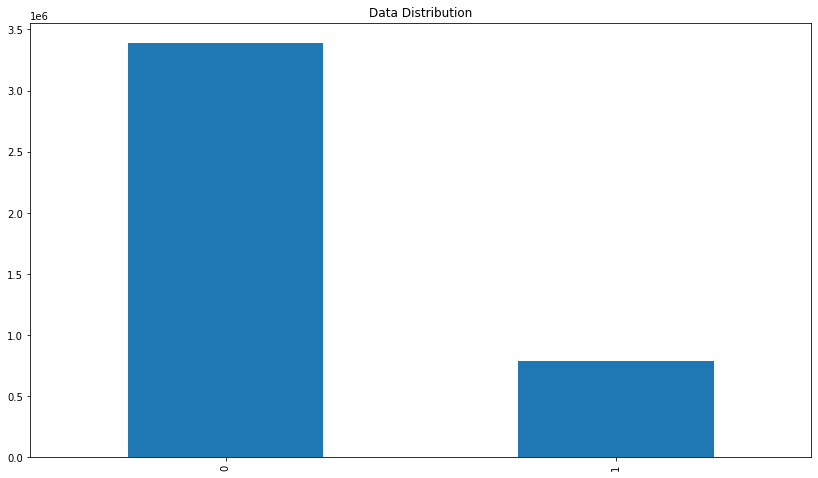

In [15]:
ax = X_train["DELAYED"].value_counts().plot(kind='bar',figsize=(14,8),title="Data Distribution")

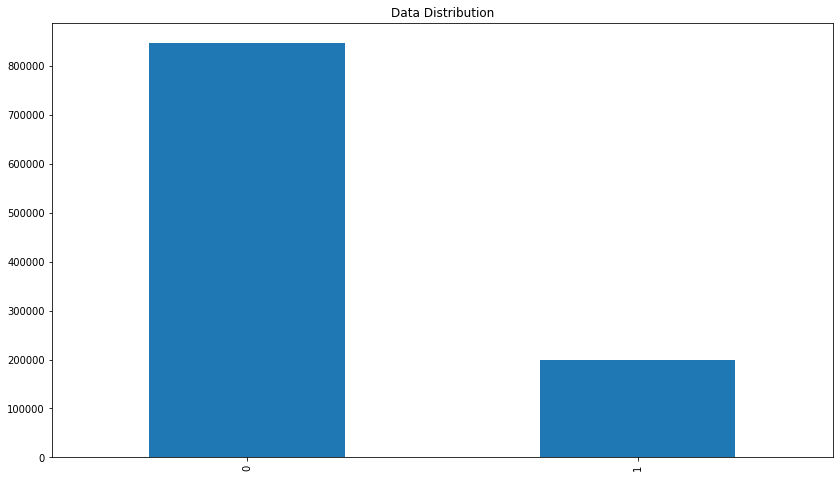

In [16]:
ax = X_test["DELAYED"].value_counts().plot(kind='bar',figsize=(14,8),title="Data Distribution")

In [17]:
X_train.pop('DELAYED')
X_test.pop('DELAYED')
print ('Training Data Shape',X_train.shape, y_train.shape)
print ('Testing Data Shape',X_test.shape, y_test.shape)

Training Data Shape (4177600, 23) (4177600,)
Testing Data Shape (1044400, 23) (1044400,)


## The following cells are using RandomForrestlClassifier to build the model for the given data
## Typically data scientist tries with multiple algorith to find the right fit for the given problem.
## It is upto you to execute and enhance the code and use MlFlow to comapre different alogithms.

In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

#n_jobs = -1 will use all the cores
forest_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [21]:
# to save time for the example, we have used minimum paramaters
# this surely can be improved for a better model

# criterion = ['gini', 'entropy']
# n_estimators = [15,22]
# max_depth = [15,30]
# min_samples_split = [6,8]
# min_samples_leaf = [10,12]

n_estimators = [15, 22]
criterion = ['gini']
max_depth = [15, 30]

# Merge the list into the variable
hyperparameters = dict(n_estimators = n_estimators , criterion = criterion, max_depth=max_depth)

model = GridSearchCV(forest_clf, hyperparameters, verbose=0)
rf_best_model = model.fit(X_train,y_train)

2022/03/21 23:01:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'f0633ae33810433c87d5f847a305ff7d', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/03/22 00:26:46 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/app-root/lib64/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator."
2022/03/22 00:26:57 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/app-root/lib64/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function `plot_roc_curve` is deprecated in 1.0 and will be removed in

In [22]:
y_test_pred = rf_best_model.predict(X_test)
# y_test_pred = cross_val_predict(rf_best_model, X_test, y_test, cv=3)

In [24]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(y_test, y_test_pred)

array([[845005,   1138],
       [195374,   2883]])

In [25]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_test, y_test_pred)

0.7169858244217856